In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import json
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import collections
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV
import datetime, time
import pytz
import statsmodels.api as stats_api
import pickle as pickle_
import csv

/Users/satya/Anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Popularity Prediction

#### Initialize variables

In [2]:
hashtags = ['#gopatriots','#nfl','#sb49','#gohawks','#patriots','#superbowl'] #using only one tag
#hashtags = ['#sb49','#gohawks','#patriots','#superbowl'] #using only one tag
df_map = {} # to store dfs for each file

#### Reading files into dataframes and storing

In [3]:
import os
df_columns = ['timestamp','tweet_id','author_id','followers','retweets','title','location']
bypass = False
for hashtag in hashtags:
    df = pd.DataFrame(columns=df_columns)
    lno = 0
    print("Processing ",hashtag)
    with open("tweet_data/tweets_"+hashtag+".txt", "r") as file_obj:
        if(not os.path.isfile('temp/'+hashtag+'.csv') or bypass):
            writer=csv.writer(open('temp/'+hashtag+'.csv','w'))
            writer.writerow(df_columns)
            line = file_obj.readline()
            while(line):
                if(lno%20000 == 0):
                    print(lno)
                j = json.loads(line)
                lno+=1
                timestamp =j['citation_date']
                followers =j['author']['followers']
                retweets = j['metrics']['citations']['total']
                author_id = j['author']['url']
                tweet_id = j['tweet']['id']
                title = j['title']
                location=j['tweet']['user']['location']
                writer.writerow([timestamp,tweet_id,author_id,followers,retweets,title,location])
                line = file_obj.readline()
        else:
            print("File Exists!")
            #writer.close()

Processing  #gopatriots
File Exists!
Processing  #nfl
File Exists!
Processing  #sb49
File Exists!
Processing  #gohawks
File Exists!
Processing  #patriots
File Exists!
Processing  #superbowl
File Exists!


In [4]:
df_map = {}

In [84]:
for hashtag in hashtags:
    print('loaded dataframe',hashtag)
    df_map[hashtag] = pd.read_csv('temp/'+hashtag+'.csv')


loaded dataframe #gopatriots
loaded dataframe #nfl
loaded dataframe #sb49
loaded dataframe #gohawks
loaded dataframe #patriots
loaded dataframe #superbowl


## 1.1 Statistics

In [158]:
tweets_hrly = {}
retweets_avg = {}
followers_hrly = {}
tweets_cnt = {}
retweets_cnt = {}
followers_cnt = {}

for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag]
    sec = df['timestamp'].max() - df['timestamp'].min()   
    tweets_cnt[hashtag] = df['tweet_id'].count()
    retweets_cnt[hashtag] = df['retweets'].sum()
    followers_cnt[hashtag] = df['followers'].sum()
    tweets_hrly[hashtag] = (tweets_cnt[hashtag]*3600)/sec
    retweets_avg[hashtag] = (retweets_cnt[hashtag])/tweets_cnt[hashtag]
    followers_hrly[hashtag] = (followers_cnt[hashtag])/tweets_cnt[hashtag]    


#gopatriots
#nfl
#sb49
#gohawks
#patriots
#superbowl


In [38]:
print('Tweets Count : ',tweets_cnt)
print('Tweets Avg. hourly',tweets_hrly)
print('Retweets Count : ',retweets_cnt)
print('Retweets Avg. hourly',retweets_avg)

print('Followers Count : ',followers_cnt)
print('Followers Avg. hourly',followers_cnt)

Tweets Count :  {'#gopatriots': 26232, '#nfl': 259024, '#sb49': 826951, '#gohawks': 188136, '#patriots': 489713, '#superbowl': 1348761}
Tweets Avg. hourly {'#gopatriots': 45.694510573562027, '#nfl': 441.3234311373958, '#sb49': 1419.8879074871904, '#gohawks': 325.3715913043311, '#patriots': 834.55550916418849, '#superbowl': 2309.9309809384081}
Retweets Count :  {'#gopatriots': 36727, '#nfl': 398517, '#sb49': 2076597, '#gohawks': 379022, '#patriots': 873068, '#superbowl': 3221210}
Retweets Avg. hourly {'#gopatriots': 1.4000838670326319, '#nfl': 1.5385331089011056, '#sb49': 2.5111487863247035, '#gohawks': 2.014617085512608, '#patriots': 1.7828156491659402, '#superbowl': 2.3882733857221554}
Followers Count :  {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots': 1620939662.0, '#superbowl': 11948576274.0}
Followers Avg. hourly {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots'

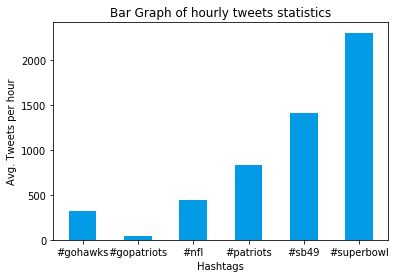

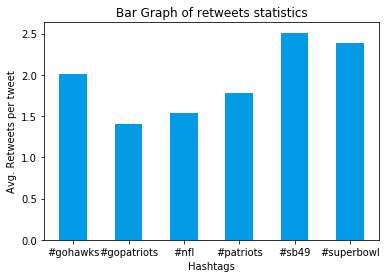

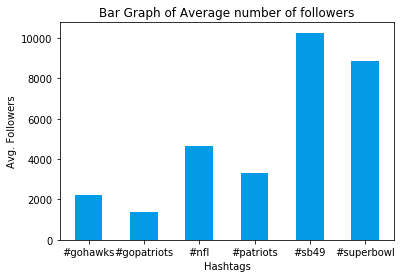

In [159]:
plt.bar(tweets_hrly.keys(),tweets_hrly.values(), width=0.5, color='#039BE5')
plt.title('Bar Graph of hourly tweets statistics')
plt.xlabel('Hashtags')
plt.ylabel('Avg. Tweets per hour')
plt.show()
plt.bar(retweets_avg.keys(),retweets_avg.values(), width=0.5, color='#039BE5')
plt.title('Bar Graph of retweets statistics')
plt.xlabel('Hashtags')
plt.ylabel('Avg. Retweets per tweet')
plt.show()
plt.bar(followers_hrly.keys(),followers_hrly.values(), width=0.5, color='#039BE5')
plt.title('Bar Graph of Average number of followers')
plt.xlabel('Hashtags')
plt.ylabel('Avg. Followers')
plt.show()

#### Returns the hour number from timestamp

In [160]:
pst_tz = pytz.timezone('US/Mountain')
def getHourofDay(timestamp):
    #print(timestamp)
    return datetime.datetime.fromtimestamp(timestamp, pst_tz).hour

    
def getHour(timestamp):
    return datetime.datetime.fromtimestamp(int(timestamp/3600)*3600, pst_tz)

#gopatriots
                  timestamp  tweet_id
0 2015-01-14 02:00:00-07:00         1
447
#nfl
                  timestamp  tweet_id
0 2015-01-14 01:00:00-07:00        59
583
#sb49
                  timestamp  tweet_id
0 2015-01-14 05:00:00-07:00         1
541
#gohawks
                  timestamp  tweet_id
0 2015-01-14 01:00:00-07:00        30
572
#patriots
                  timestamp  tweet_id
0 2015-01-14 01:00:00-07:00        23
587
#superbowl
                  timestamp  tweet_id
0 2015-01-14 01:00:00-07:00         8
585


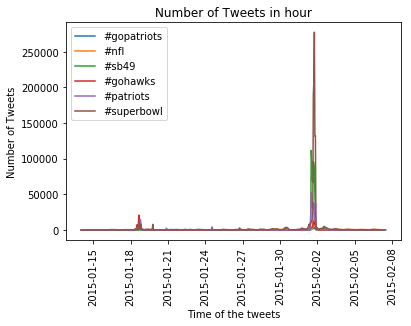

In [165]:
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp').agg({'tweet_id':'count'})
    #grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    #grouped.columns=grouped.columns.droplevel()
    grouped.reset_index(inplace=True)
    print(grouped.head(1))
    plt.plot(list(grouped['timestamp']),list(grouped['tweet_id']),label=hashtag)
    plt.title('Number of Tweets in hour')
    print(len(list(grouped['tweet_id'])))
plt.xticks(rotation=90)
plt.ylabel('Number of Tweets')
plt.xlabel('Time of the tweets')
plt.legend()
plt.show()


## 1.2 Linear Regression

In [169]:
X_map = {}
Y_map = {}
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp').agg({'followers': ['sum', 'max'],'tweet_id':'count', 'retweets':'sum'})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    grouped.reset_index(inplace=True)
    grouped['hour_of_day'] = grouped.apply(lambda x: x['timestamp'].hour, axis=1)
    X_map[hashtag] = grouped.drop(['timestamp'],axis=1)
    print(grouped.head(1))
    Y_map[hashtag] = grouped['tweet_id_count']
    

#gopatriots
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 02:00:00-07:00        10955.0        10955.0               1   

   retweets_sum  hour_of_day  
0             4            2  
#nfl
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 01:00:00-07:00       104976.0        10658.0              59   

   retweets_sum  hour_of_day  
0            67            1  
#sb49
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 05:00:00-07:00           59.0           59.0               1   

   retweets_sum  hour_of_day  
0             2            5  
#gohawks
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 01:00:00-07:00        24989.0        12922.0              30   

   retweets_sum  hour_of_day  
0           460            1  
#patriots
                  timestamp  followers_sum  followers_max  tweet_id_count  \
0 2015-01-14 

#### Method to merge n prev hours

In [153]:
#n : number of hours you want to merge
#f : features in each row
#x : X_map value
#y : Y_map value
def getprev_n_merged(n,f,X,y):
    print(X.head(1))
    X = X.as_matrix()
    X_new = []
    rnew = []
    for row in X[:n]:
        rnew = rnew + list(row)
    
    X_new.append(rnew)
    for row in X[n:]:
        rnew = rnew[f:]+list(row)
        X_new.append(rnew)
    print(len(X_new[:-1]),len(list(y[n:])))
    return X_new[:-1],list(y)[n:]

In [170]:
for n in range(1,3):
    for hashtag in hashtags:
        print(hashtag)
        X,y= getprev_n_merged(n,5,X_map[hashtag],Y_map[hashtag])
        model = stats_api.OLS(y,X).fit()
        preds = model.predict(X)
        print("RMSE : ",np.sqrt(mean_squared_error(y,preds)))
        print(model.summary())
        f= open("summary1.2/"+str(n)+'_'+hashtag+".csv","w+")
        f.write(model.summary().as_csv())
        f.close()


#gopatriots
   followers_sum  followers_max  tweet_id_count  retweets_sum  hour_of_day
0        10955.0        10955.0               1             4            2
446 446
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     156.8
Date:                Sat, 10 Mar 2018   Prob (F-statistic):           1.85e-95
Time:                        15:46:50   Log-Likelihood:                -3017.4
No. Observations:                 446   AIC:                             6045.
Df Residuals:                     441   BIC:                             6065.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err        

445 445
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     103.3
Date:                Sat, 10 Mar 2018   Prob (F-statistic):          3.30e-108
Time:                        15:46:51   Log-Likelihood:                -2967.9
No. Observations:                 445   AIC:                             5956.
Df Residuals:                     435   BIC:                             5997.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0017      0.000     -8.042 

# PART 3

In [192]:
def plot_sentiment(hashtags,sentiment_map):
    for hashtag in hashtags:
        plt.title("Total Sentiment : subjectivity*polarity")
        plt.plot(sentiment_map[hashtag]['timestamp'],sentiment_map[hashtag]['sentiment'],label=hashtag)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()
    for hashtag in hashtags:
        plt.title("Average Total Sentiment : subjectivity*polarity")
        plt.plot(sentiment_map[hashtag]['timestamp'],[(a/b) for a,b in zip(list(sentiment_map[hashtag]['sentiment']),list(sentiment_map[hashtag]['tweet_id'] ))],label=hashtag)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

In [193]:
from textblob import TextBlob as tb
import re
i=0
def clean_tweet(t):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", t).split())
def get_sentiment(t):
    global i
    i+=1
    if(i%100000 == 0):
        print(i)
    analysis = tb(clean_tweet(t))
    return analysis.sentiment.polarity*analysis.sentiment.subjectivity
def get_time_bin(t,h):
    return datetime.datetime.fromtimestamp(int(t/(3600*h))*3600*h, pst_tz)    

In [194]:
slist = []

In [195]:
def perform_sentiment_analysis(hashtags,df_map,hrs):
    sentiment_map={}
    for hashtag in hashtags:
        i = 0
        print(hashtag)
        df = df_map[hashtag].copy()
        df['sentiment'] = df['title'].apply(lambda x:get_sentiment(x))
        df['timestamp'] = df['timestamp'].apply(lambda x:get_time_bin(x,hrs) )
        grouped = df.groupby('timestamp').agg({'sentiment':'sum','tweet_id':'count'})
        grouped.reset_index(inplace=True)
        sentiment_map[hashtag]=grouped
    plot_sentiment(hashtags,sentiment_map)
    return sentiment_map    

#gopatriots
#nfl
100000
200000
#sb49
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
#gohawks
1200000
1300000
#patriots
1400000
1500000
1600000
1700000
#superbowl
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000


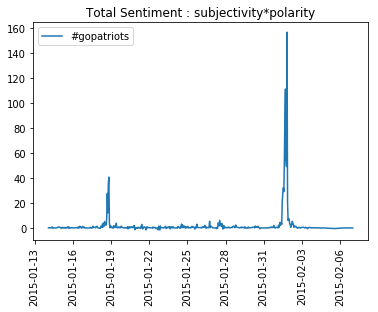

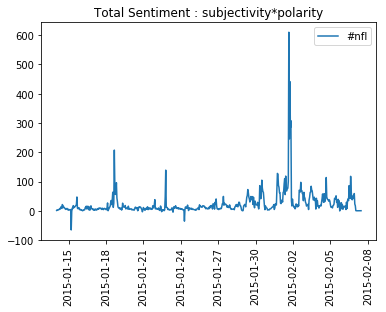

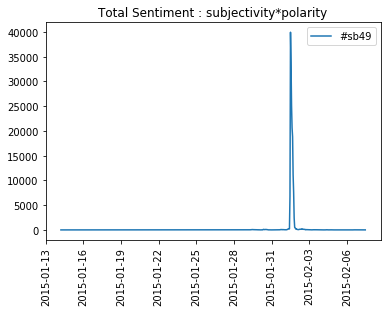

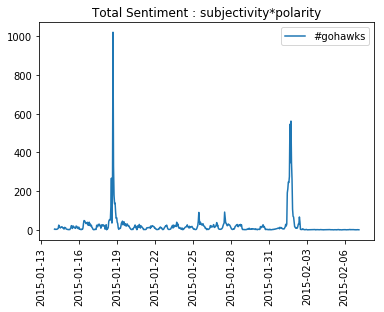

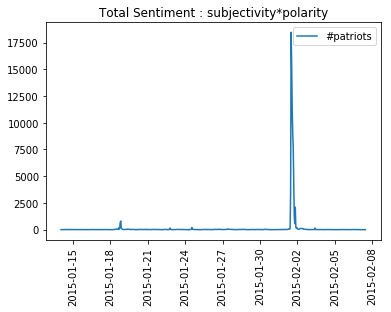

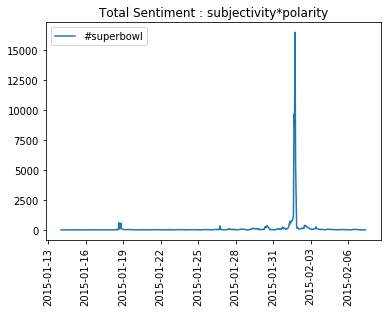

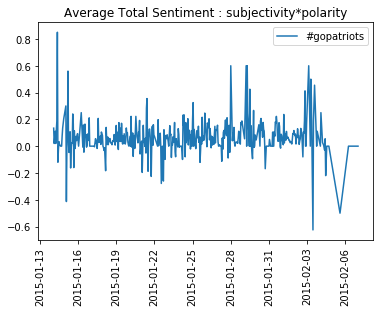

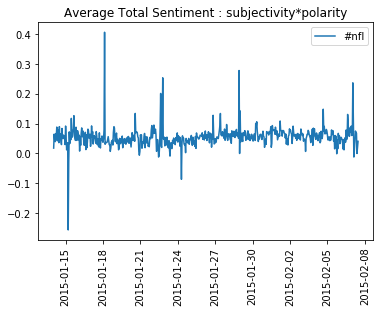

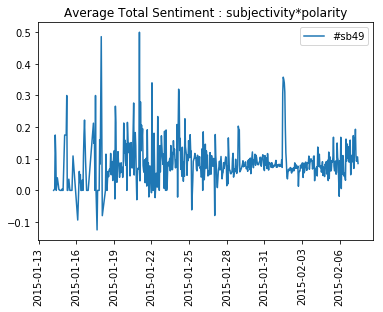

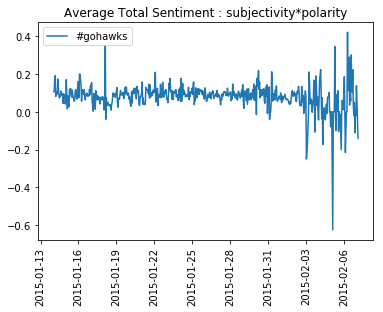

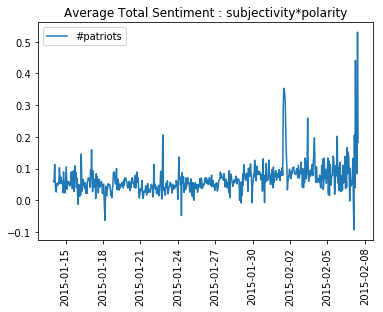

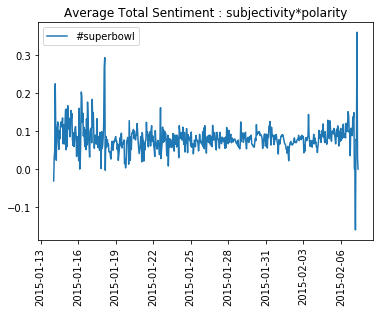

#gopatriots
#nfl
3200000
3300000
3400000
#sb49
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
#gohawks
4300000
4400000
#patriots
4500000
4600000
4700000
4800000
4900000
#superbowl
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000


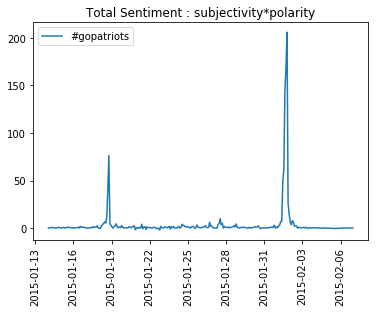

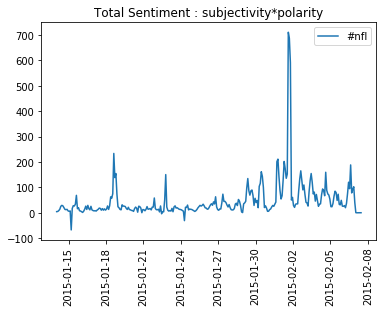

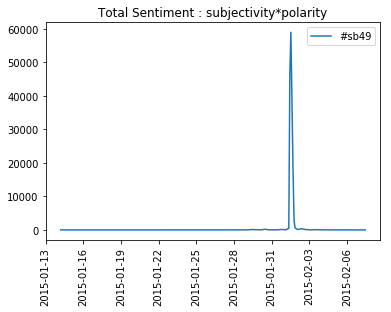

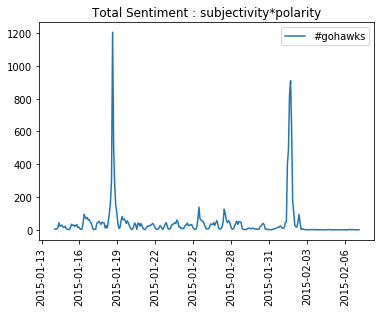

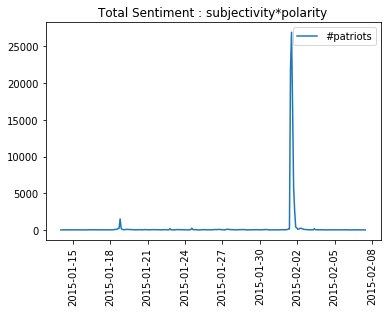

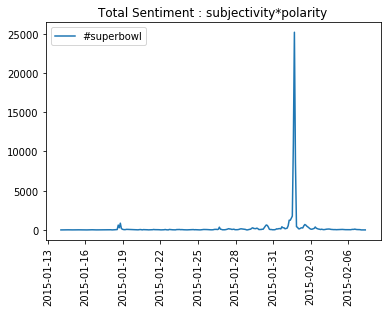

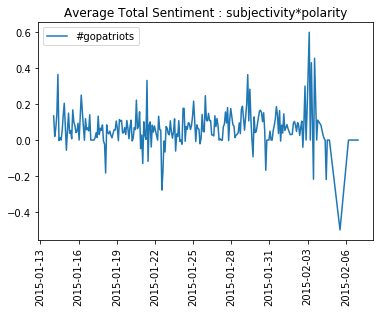

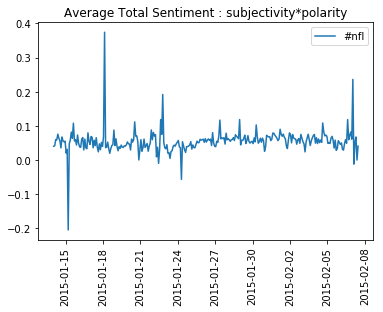

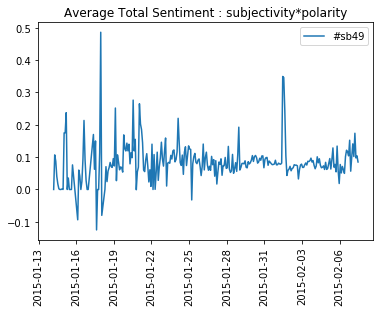

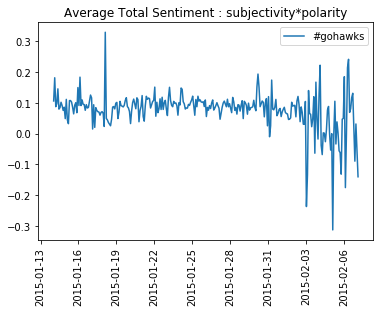

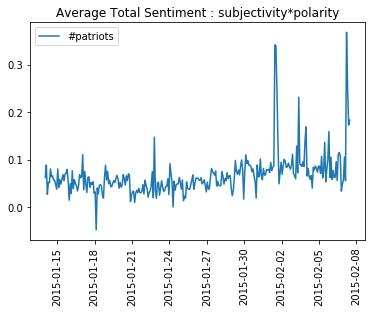

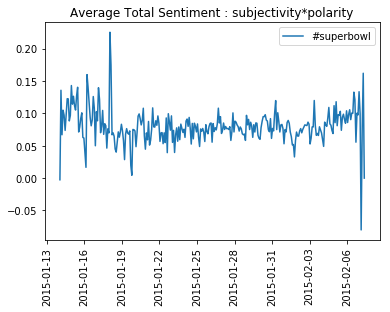

#gopatriots
6300000
#nfl
6400000
6500000
#sb49
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
#gohawks
7400000
7500000
#patriots
7600000
7700000
7800000
7900000
8000000
#superbowl
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000


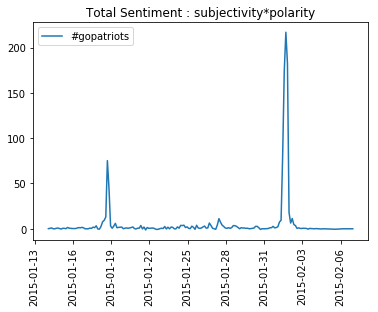

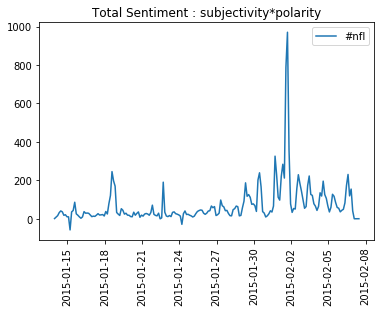

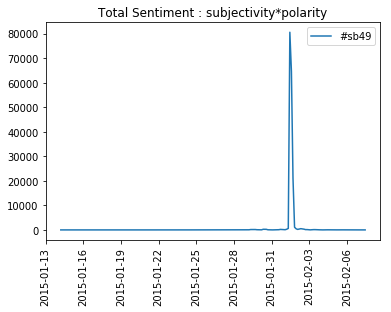

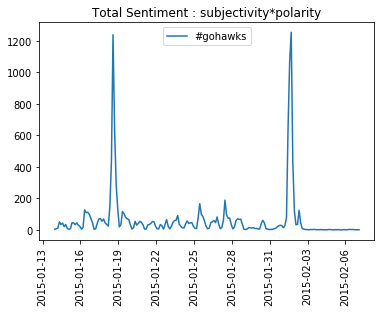

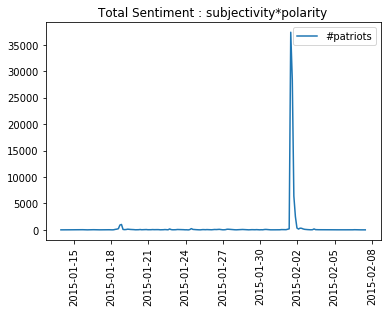

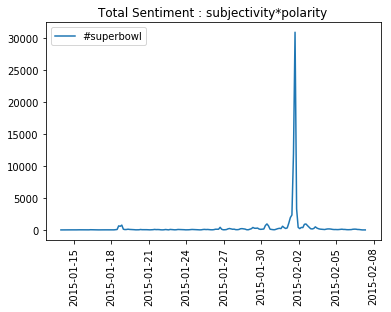

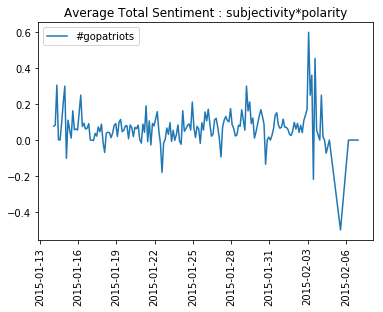

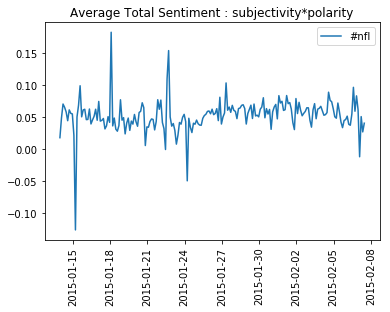

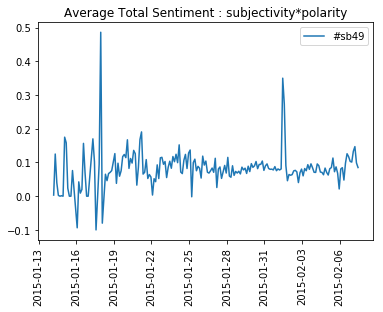

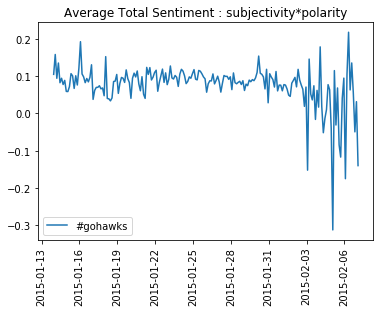

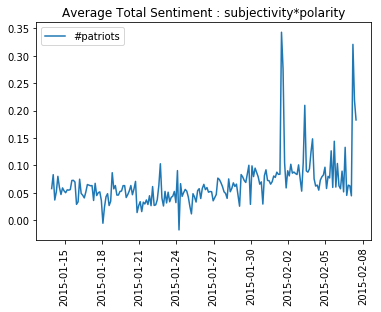

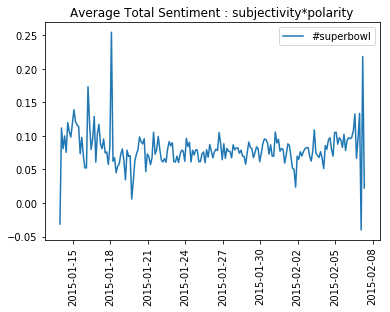

#gopatriots
#nfl
9500000
9600000
9700000
#sb49
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
#gohawks
10600000
10700000
#patriots
10800000
10900000
11000000
11100000
11200000
#superbowl
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000
12400000
12500000


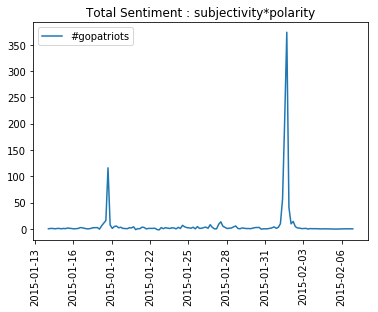

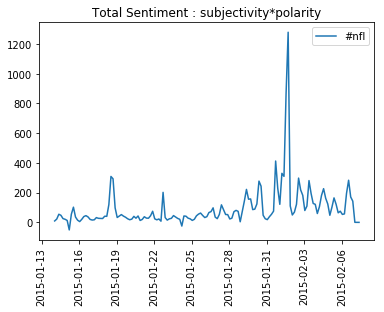

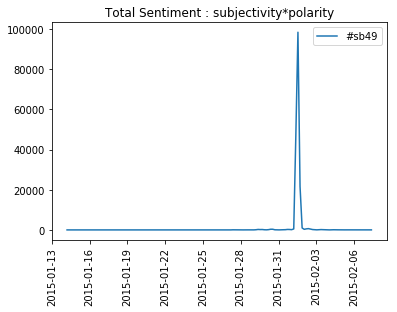

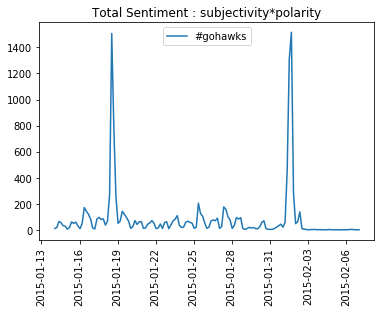

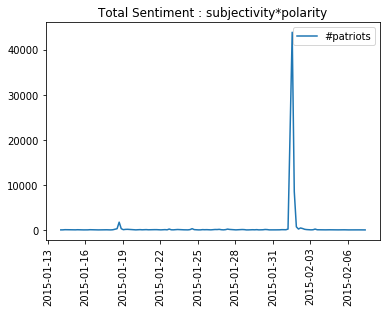

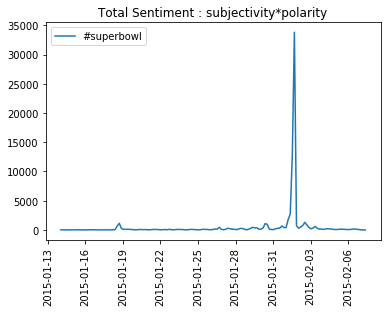

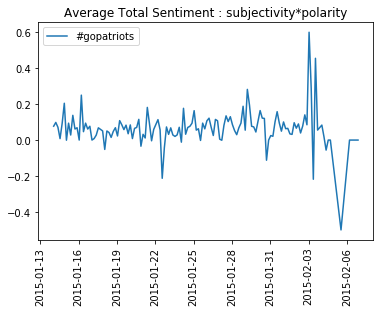

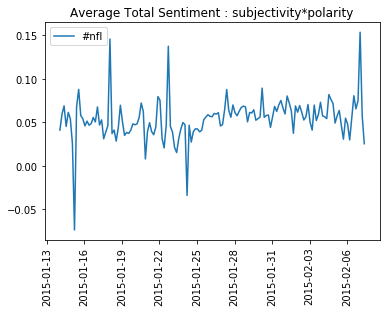

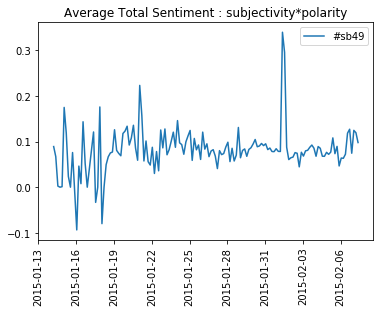

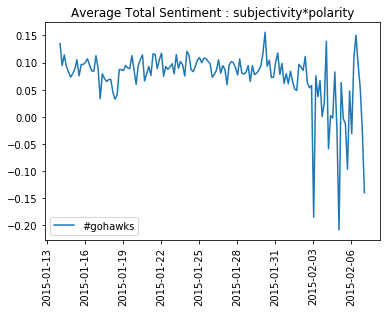

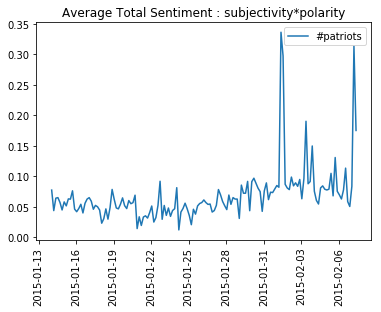

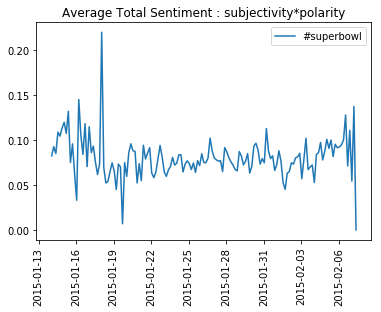

#gopatriots
#nfl
12600000
12700000
12800000
#sb49
12900000
13000000
13100000
13200000
13300000
13400000
13500000
13600000
#gohawks
13700000
13800000
#patriots
13900000
14000000
14100000
14200000
14300000
#superbowl
14400000
14500000
14600000
14700000
14800000
14900000
15000000
15100000
15200000
15300000
15400000
15500000
15600000


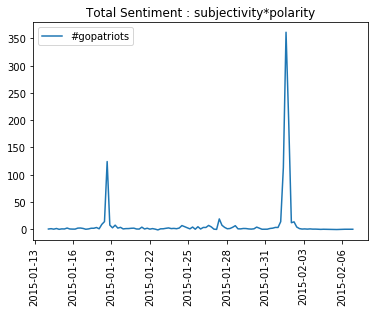

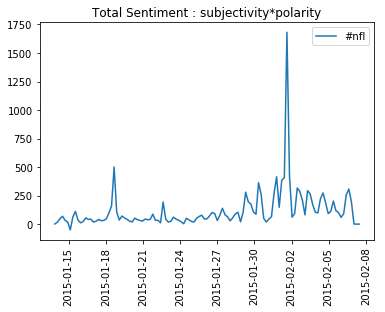

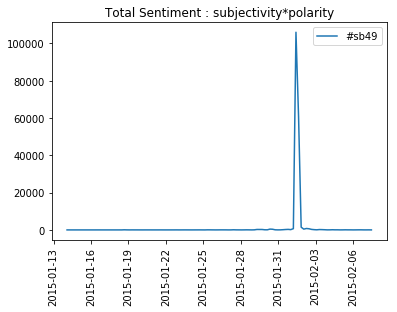

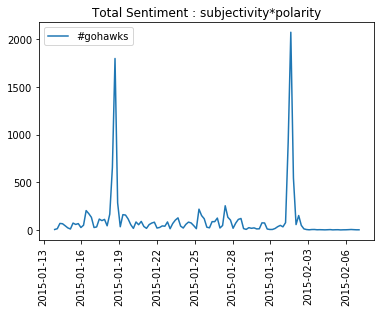

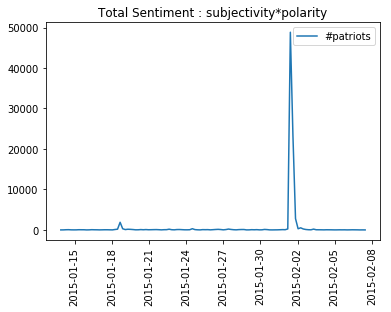

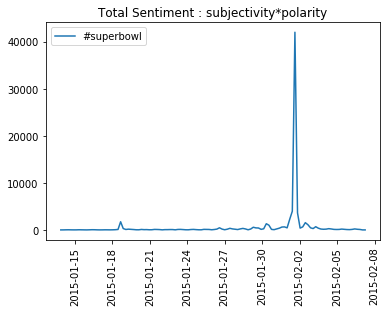

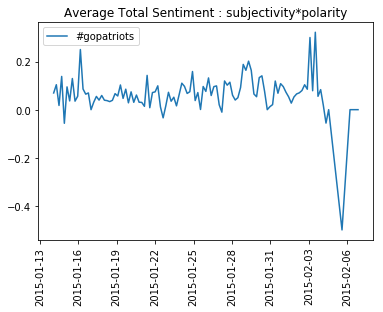

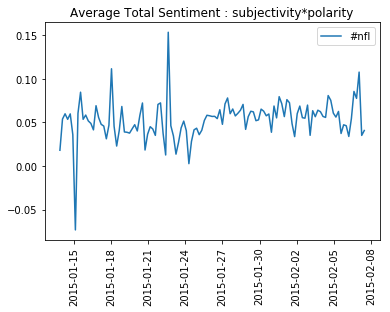

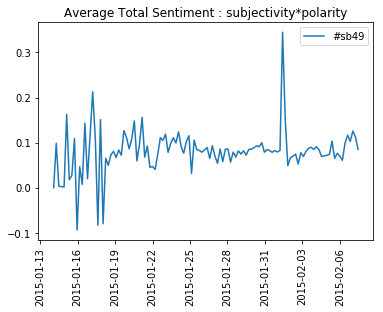

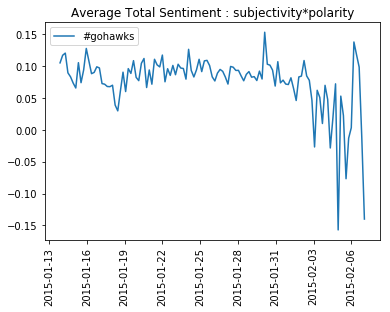

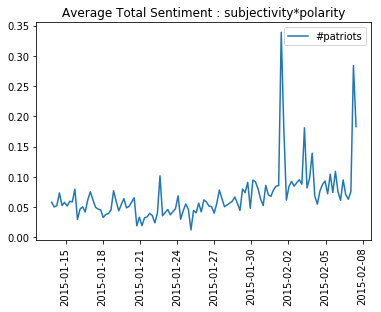

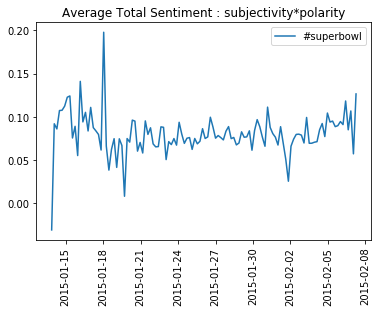

In [196]:
for hrs in range(1,6):
    slist.append(perform_sentiment_analysis(hashtags,df_map,hrs))